In [2]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_node import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jaxinterp2d import interp2d
import scipy.io

/var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_23693/4001090329.py:5: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


ImportError: cannot import name 'eval_Cauchy_aniso' from 'utils' (/Users/vt/Library/CloudStorage/OneDrive-purdue.edu/Research/node_inv/utils.py)

In [2]:
from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



## 1. Generate data + pretraining

In [14]:
f = scipy.io.loadmat('data/PU1_034_3/NEWLYFIXED_PU1_034_3.mat')

# These are the limits of the square region in the middle.
i1 = 57
i2 = 236
i3 = 55
i4 = 218
nx = i4-i3
ny = i2-i1

x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
x, y = np.meshgrid(x,y)

epsx = np.zeros([50,ny,nx])
epsy = np.zeros([50,ny,nx])
aux1 = np.zeros([50,291,275])
aux2 = np.zeros([50,291,275])
for i in range(50):
    aux1[i] = f['data_dic_save']['strains'][0,0][0,i][0]
    aux2[i] = f['data_dic_save']['strains'][0,0][0,i][2]
    epsx[i] = aux1[i][i1:i2, i3:i4]
    epsy[i] = aux2[i][i1:i2, i3:i4]



F_data = pd.read_csv('data/PU1_034_3/PU1_034_3Data.csv')
F_data = F_data[F_data.SetName=='Equibiaxial']
F_data = F_data[F_data.Cycle=='2-Recover'].reset_index()
Fx = jnp.flip(F_data['XForce_mN'].to_numpy().astype(float))
Fy = jnp.flip(F_data['YForce_mN'].to_numpy().astype(float))
Fx = (Fx-Fx[0])/Fx[-1]*1000
Fy = (Fy-Fy[0])/Fy[-1]*1000



Fx = Fx[::2]
Fy = Fy[::2]
epsx = epsx[::2]
epsy = epsy[::2]

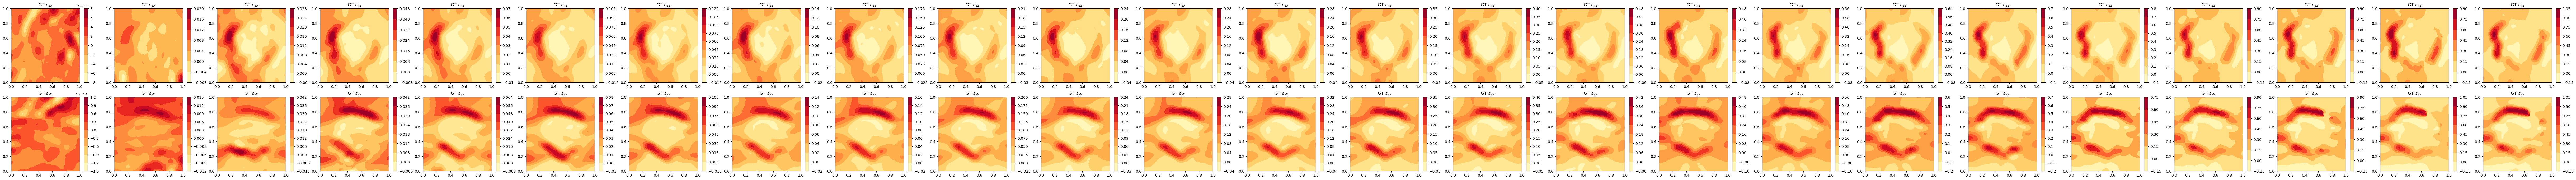

In [4]:
fig, ax = plt.subplots(2,len(epsx),figsize=(len(epsx)*5,8))
for i in range(len(epsx)):
    cf = ax[0,i].contourf(x,y,epsx[i], cmap='YlOrRd')
    fig.colorbar(cf, ax = ax[0,i])
    cf = ax[1,i].contourf(x,y,epsy[i], cmap='YlOrRd')
    fig.colorbar(cf, ax = ax[1,i])

    ax[0,i].set(title='GT $\epsilon_{xx}$')
    ax[1,i].set(title='GT $\epsilon_{yy}$')

In [5]:
node_X = np.array([x.flatten(), y.flatten()]).T
t_hist = np.arange(len(epsx)).reshape([-1,1]).astype(float)
t_hist = np.repeat(t_hist, axis=1, repeats=epsx.shape[1]*epsx.shape[2])
# strains = np.vstack([t_hist.flatten(), epsx.flatten(), epsy.flatten()])

inp2 = []
for i in range(len(epsx)):
    aux = np.vstack([node_X[:,0], node_X[:,1], np.ones(len(node_X))*i, epsx[i].flatten(), epsy[i].flatten()]).T
    inp2.append(aux)
inp = np.array(inp2).reshape([-1,5])

it 1000, train loss = 5.231073e-05
it 2000, train loss = 3.150478e-05
it 3000, train loss = 2.335493e-05
it 4000, train loss = 1.811000e-05
it 5000, train loss = 1.482823e-05
it 6000, train loss = 1.224375e-05
it 7000, train loss = 9.950876e-06
it 8000, train loss = 8.654168e-06
it 9000, train loss = 7.594758e-06
it 10000, train loss = 6.695784e-06
it 11000, train loss = 6.301340e-06
it 12000, train loss = 5.820102e-06
it 13000, train loss = 5.581254e-06
it 14000, train loss = 5.260709e-06
it 15000, train loss = 5.092650e-06
it 16000, train loss = 4.824589e-06
it 17000, train loss = 4.896799e-06
it 18000, train loss = 4.521046e-06
it 19000, train loss = 4.530470e-06
it 20000, train loss = 4.476796e-06
it 21000, train loss = 4.133283e-06
it 22000, train loss = 4.109632e-06
it 23000, train loss = 3.990237e-06
it 24000, train loss = 3.985327e-06
it 25000, train loss = 3.844987e-06
it 26000, train loss = 3.761937e-06
it 27000, train loss = 3.749863e-06
it 28000, train loss = 3.679753e-06
i

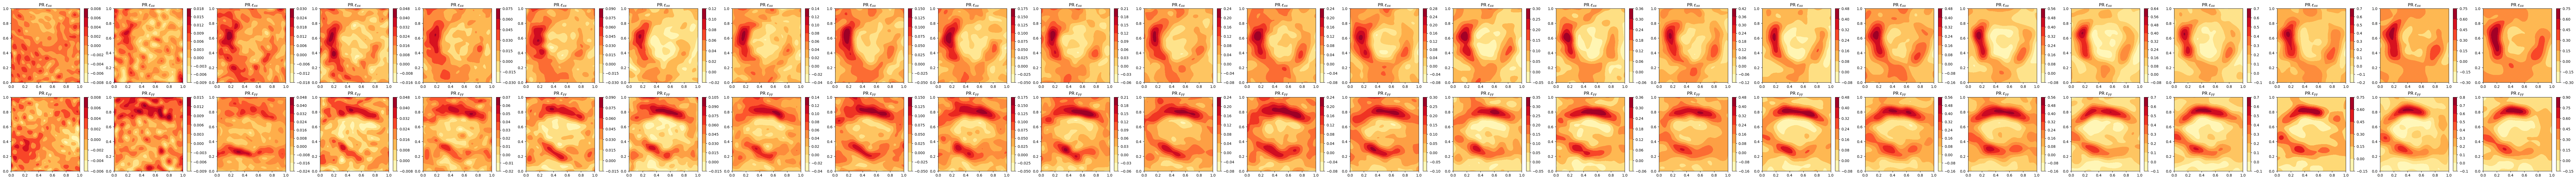

In [6]:
# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,t and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = ff_nn(inp, params)
    out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

n_ff = 40 # 10 cosines and 10 sines in the fourier features
n_inp = 3 # x, y, lmb
ff_params = np.random.normal(size=n_inp*n_ff).reshape([n_inp,n_ff])
nn_layers = [2*n_ff,40,40,2]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params = [ff_params, nn_params]

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

coord_2_strain_params, train_loss, _ = train(loss, inp, get_params, opt_update, opt_state, key, nIter = 40000, print_freq=1000, batch_size=20000)

fig, ax = plt.subplots(2,len(epsx),figsize=(len(epsx)*5,8))
for i in range(len(epsx)):
    inp = inp2[i]
    epsx_pr, epsy_pr = ff_nn(inp[:,:3], coord_2_strain_params).T
    epsx_pr = epsx_pr.reshape([epsx.shape[1], epsx.shape[2]])
    epsy_pr = epsy_pr.reshape([epsy.shape[1], epsy.shape[2]])
    cf = ax[0,i].contourf(x,y,epsx_pr, cmap='YlOrRd')
    fig.colorbar(cf, ax = ax[0,i])
    cf = ax[1,i].contourf(x,y,epsy_pr, cmap='YlOrRd')
    fig.colorbar(cf, ax = ax[1,i])

    ax[0,i].set(title='PR $\epsilon_{xx}$')
    ax[1,i].set(title='PR $\epsilon_{yy}$')

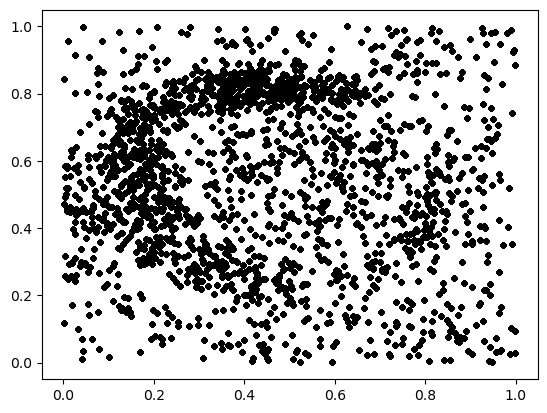

In [7]:
nrow = 40
ncol = 40
sgmx_mean = Fx/nrow
sgmy_mean = Fy/ncol

# inp = np.array(np.meshgrid(np.linspace(0,1,nrow), np.linspace(0,1,ncol))).reshape([2,-1]).T
# Rather than using a regular grid, choose points for training such that the regions of high/low strain are more likely to be picked.
epsx_mean = np.mean(epsx[-10:], axis=0) #Use the last 10 steps only
epsy_mean = np.mean(epsy[-10:], axis=0)
mps = np.max([np.abs(epsx_mean), np.abs(epsy_mean)], axis=0)
mps_mean = np.mean(mps)
mps_max  = np.max(mps)
diff_max = np.abs(mps_max-mps_mean)

n = 0
inp = []
while n < 2000:
    aux = np.random.uniform(size=2)
    aux2 = np.hstack([aux, len(epsx)-1])[None,:]
    epsx_pr, epsy_pr = ff_nn(aux2, coord_2_strain_params).T
    mps = np.maximum(np.abs(epsx_pr), np.abs(epsy_pr))
    diff = np.abs(mps - mps_mean) + 0.02
    
    if np.random.uniform() < diff:
        inp.append(aux)
        n+=1
inp = np.array(inp)

inp2 = []
for i in range(len(epsx)):
    aux = np.ones(len(inp))*i
    aux = np.hstack([inp, aux[:,None]])
    inp2.append(aux)
inp = np.array(inp2).reshape([-1,3])

plt.plot(inp[:,0], inp[:,1], 'k.')

In [9]:
# Assume that every point has the same stress at a point in time, fit the hypernetwork with this assumption
key = random.PRNGKey(0)
n_neurons = 4
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

def loss(Lambda_params, inp, key):
    eps = ff_nn(inp, coord_2_strain_params)
    epsx, epsy = eps
    model_params = ff_nn(inp[:2], Lambda_params)
    model   = NODE_model_aniso(unravel(model_params))
    sgm = eval_Cauchy_aniso(epsx+1.0,epsy+1.0, model)
    sgmx_pr, sgmy_pr = sgm[0,0], sgm[1,1]
    sgmx_gt_t = sgmx_mean[inp[2].astype(int)]
    sgmy_gt_t = sgmy_mean[inp[2].astype(int)]
    return np.mean((sgmx_pr-sgmx_gt_t)**2 + (sgmy_pr-sgmy_gt_t)**2)
loss_vmap = lambda Lambda_params, inp, aux: jnp.mean(vmap(loss, in_axes=(None, 0, None))(Lambda_params, inp, None))

n_ff = 30
ff_params = np.random.normal(size=2*n_ff).reshape([2,n_ff])
nn_layers = [2*n_ff,100,100,100,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params = [ff_params, nn_params]
opt_init, opt_update, get_params = optimizers.adam(5.e-5) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

Lambda_params, train_loss, _ = train(loss_vmap, inp, get_params, opt_update, opt_state, key, nIter = 30000, print_freq=1000)

it 1000, train loss = 2.161127e+01
it 2000, train loss = 1.624095e+01
it 3000, train loss = 1.389060e+01
it 4000, train loss = 1.284725e+01
it 5000, train loss = 1.237073e+01
it 6000, train loss = 1.203951e+01
it 7000, train loss = 1.179933e+01
it 8000, train loss = 1.166948e+01
it 9000, train loss = 1.158238e+01
it 10000, train loss = 1.151428e+01
it 11000, train loss = 1.146194e+01
it 12000, train loss = 1.144801e+01
it 13000, train loss = 1.138246e+01
it 14000, train loss = 1.135088e+01
it 15000, train loss = 1.132642e+01
it 16000, train loss = 1.128442e+01
it 17000, train loss = 1.126054e+01
it 18000, train loss = 1.133456e+01
it 19000, train loss = 1.137655e+01
it 20000, train loss = 1.119793e+01
it 21000, train loss = 1.128905e+01
it 22000, train loss = 1.123026e+01
it 23000, train loss = 1.179046e+01
it 24000, train loss = 1.112883e+01
it 25000, train loss = 1.123959e+01
it 26000, train loss = 1.110323e+01
it 27000, train loss = 1.108164e+01
it 28000, train loss = 1.109938e+01
i

In [10]:
lmbx_hist = jnp.flip(F_data['XSize_um'].to_numpy())
lmby_hist = jnp.flip(F_data['YSize_um'].to_numpy())
lmbx_hist = lmbx_hist/lmbx_hist[0]
lmby_hist = lmby_hist/lmby_hist[0]
lmbx_hist = lmbx_hist[::2]
lmby_hist = lmby_hist[::2]

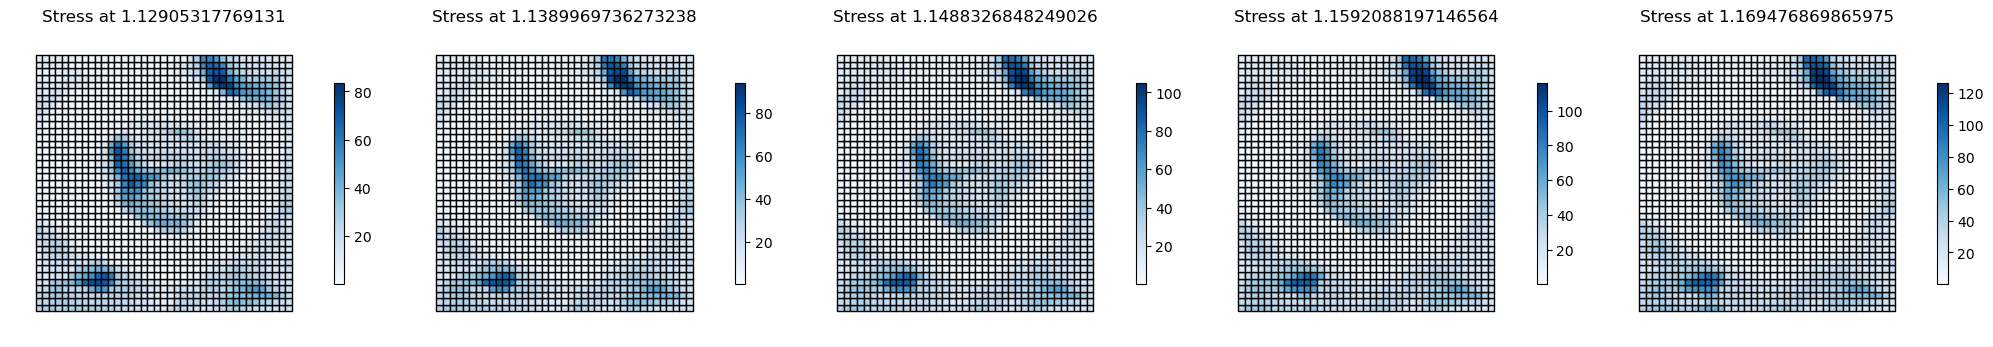

In [11]:
# Stiffness across the domain
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = nrow-1, ncol-1
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
elem_X = mesh.points[mesh.cells].mean(axis=1)


fig, axes = plt.subplots(1,5,figsize=(25,4))
for lmb, ax in zip(lmbx_hist[-5:], axes):
    c_elem = []
    for x, y in elem_X:
        Lambda_inp = jnp.array([x,y]).reshape([-1,2])
        phi = ff_nn(Lambda_inp, Lambda_params).flatten()
        mymodel = NODE_model_aniso(unravel(phi))
        c_elem.append(eval_Cauchy_aniso(lmb, lmb, mymodel)[0,0])
    c_elem = np.array(c_elem)
    plotmesh(mesh.cells, mesh.points, c_elem, title='Stress at {}'.format(str(lmb)), ax=ax); 

In [12]:
from matplotlib.cm import get_cmap
cmap = get_cmap('hsv')

/var/folders/1f/rngrmz8x3lsd60h6dd90ncwm0000gr/T/ipykernel_69984/4240714405.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('hsv')


Text(0.5, 0.98, 'Sorted version of the same figure')

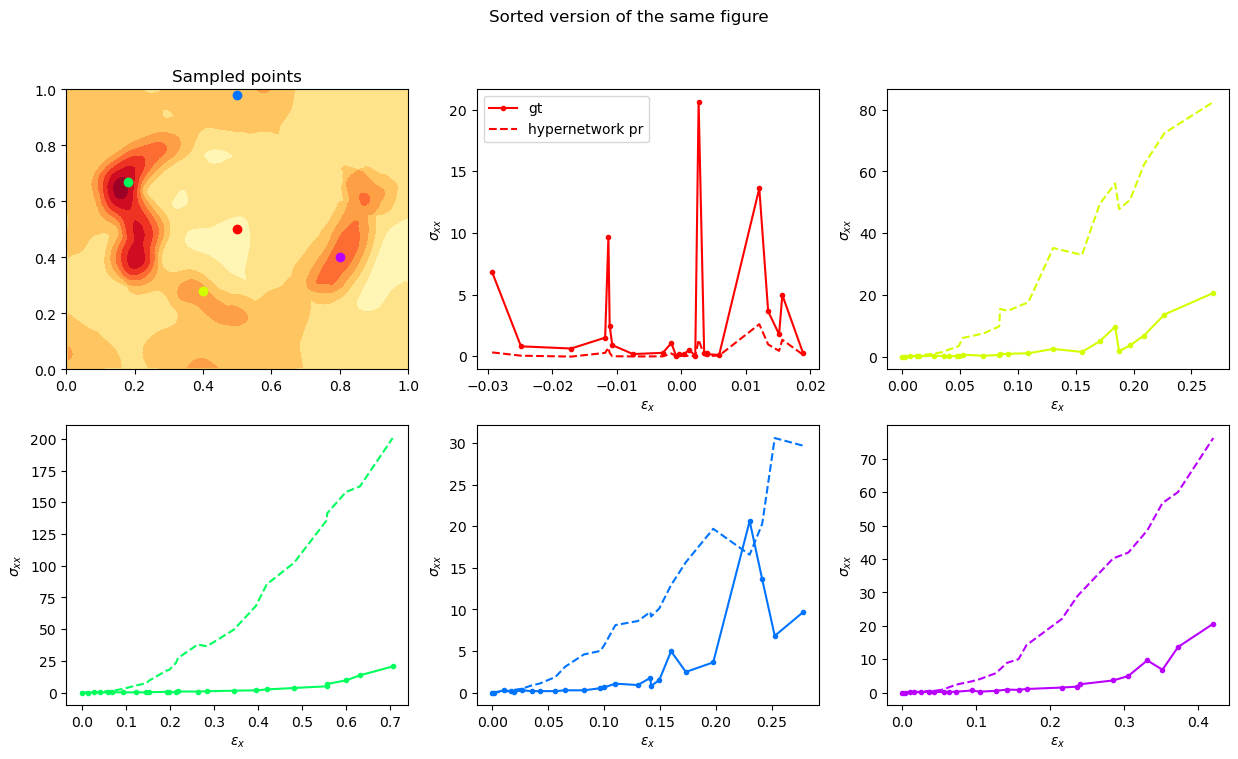

In [15]:
n_samples = 5
fig, ax = plt.subplots(2,3,figsize=(15,8))
ax = ax.flatten()
ax[0].contourf(x,y,epsx[-1], cmap='YlOrRd')
locs = np.array([[0.5, 0.5], [0.4, 0.28], [0.18, 0.67], [0.5, 0.98], [0.8, 0.4]])
ax[0].plot(locs[:,0], locs[:,1], 'k.')
ax[0].set(title='Sampled points')

for i, loc in enumerate(locs):
    epsx_gt = []
    sgmx_gt = []
    sgmx_pr = []
    for t in range(len(epsx)):
        inp = np.hstack([loc,t])[None,:]
        aux = ff_nn(inp, coord_2_strain_params)[0]
        epsx_gt.append(aux[0])
        sgmx_gt.append(sgmx_mean[t])

        phi = ff_nn(Lambda_inp, Lambda_params).flatten()
        mymodel = NODE_model_aniso(unravel(phi))
        sgmx_pr.append(eval_Cauchy_aniso(aux[0]+1.0, aux[1]+1.0, mymodel)[0,0])
        
    epsx_gt, sgmx_gt, sgmx_pr = np.array(epsx_gt), np.array(sgmx_gt), np.array(sgmx_pr)
    idx = np.argsort(epsx_gt)
    color = cmap(i / (len(locs)))
    ax[0].plot(loc[0], loc[1], marker='o', color=color)
    ax[i+1].plot(epsx_gt[idx], sgmx_gt[idx], marker='.', color=color)
    ax[i+1].plot(epsx_gt[idx], sgmx_pr[idx], '--', color=color)
    ax[i+1].set(xlabel='$\epsilon_x$', ylabel='$\sigma_{xx}$')
ax[1].legend(['gt', 'hypernetwork pr'])
fig.suptitle('Sorted version of the same figure')

In [25]:
x = np.linspace(0,1,40)
rgt_bd_X = np.array([np.ones(40), x]).T
top_bd_X = np.array([x, np.ones(40)]).T
lft_bd_X = np.array([np.zeros(40), x]).T
bot_bd_X = np.array([x, np.zeros(40)]).T
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [26]:
with open('params/murine_pre2.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, node_X, Fx, Fy, epsx, epsy, bd_X, lmbx_hist, lmby_hist, t_hist[:,0]], f)

## 2. Retrain

In [3]:
with open('params/murine_pre2.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, node_X, Fx, Fy, epsx, epsy, bd_X, lmbx_hist, lmby_hist, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [16]:
# Train
@jit
def loss(Lambda_params, X):
    div_x, div_y = divergence(Lambda_params, X, bd_X, coord_2_strain_params, NODE_w_unravel)
    F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, X, bd_X, coord_2_strain_params, NODE_w_unravel)
    t = X[1] # a scalar
    fx = Fx[jnp.array(t, int)]
    fy = Fy[jnp.array(t, int)]
    return a1*(div_x**2 + div_y**2) + a2*((F_rgt-fx)**2 + (F_top-fy)**2 + (F_lft-fx)**2 + (F_bot-fy)**2)

lr = 1e-5
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

metric1 = lambda params, X:  bd_forces(params, X, bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, X, bd_X, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [node_X, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 50000, print_freq=1000, metric_fns=[metric1, metric2])

with open('params/murine_post2.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_X, Fx, Fy, epsx, epsy, node_params, Lambda_params, val_loss, metrics], f)

it 1000, val loss = 1.418603e+07
it 2000, val loss = 5.829254e+05
it 3000, val loss = 8.119669e+05
it 4000, val loss = 6.436807e+05
it 5000, val loss = 6.764016e+05
it 6000, val loss = 5.355562e+05
it 7000, val loss = 5.411591e+05
it 8000, val loss = 3.936533e+05
it 9000, val loss = 4.611369e+05
it 10000, val loss = 4.726958e+05
it 11000, val loss = 5.057614e+05
it 12000, val loss = 5.740174e+05
it 13000, val loss = 5.645666e+05
it 14000, val loss = 5.425746e+05
it 15000, val loss = 7.511957e+05
it 16000, val loss = 7.087460e+05
it 17000, val loss = 5.966459e+05
it 18000, val loss = 7.749244e+05
it 19000, val loss = 5.742673e+05
it 20000, val loss = 5.405955e+05
it 21000, val loss = 5.006365e+05
it 22000, val loss = 5.185902e+05
it 23000, val loss = 4.094422e+05
it 24000, val loss = 5.686167e+05
it 25000, val loss = 1.404059e+06
it 26000, val loss = 4.774038e+05
it 27000, val loss = 5.067964e+05
it 28000, val loss = 5.994279e+05
it 29000, val loss = 6.054369e+05
it 30000, val loss = 5.

## 3. Test

In [17]:
with open('params/murine_post2.npy', 'rb') as f:
    coord_2_strain_params, node_X, Fx, Fy, epsx, epsy, node_params, Lambda_params, val_loss, metrics = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

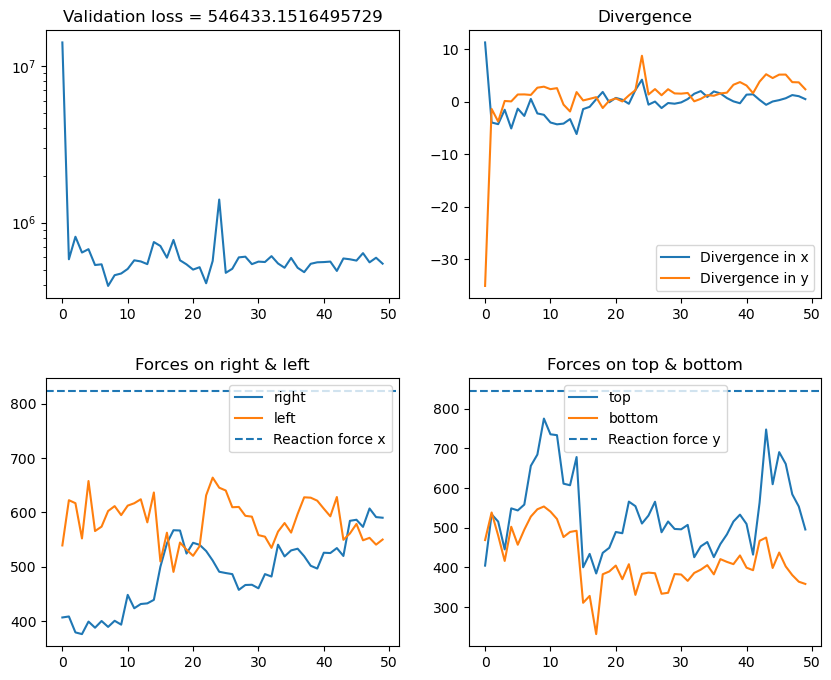

In [18]:
forces = []
div = []
for i in range(len(metrics)):
    forces.append(metrics[i][0])
    div.append(metrics[i][1])
forces = np.array(forces)
div = np.array(div)

fig, ax = plt.subplots(2,2,figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
ax[0,0].plot(val_loss)
ax[0,1].plot(div[:,0], label='Divergence in x')
ax[0,1].plot(div[:,1], label='Divergence in y')

ax[1,0].plot(forces[:,0], label='right')
ax[1,1].plot(forces[:,1], label='top')
ax[1,0].plot(forces[:,2], label='left')
ax[1,1].plot(forces[:,3], label='bottom')

ax[1,0].axhline(Fx[-1], linestyle='--', label='Reaction force x')
ax[1,1].axhline(Fy[-1], linestyle='--', label='Reaction force y')

# ax[0,0].set(yscale='log')
ax[0,0].set(title='Validation loss = ' + str(val_loss[-1]), yscale = 'log')
ax[0,1].set(title='Divergence')
ax[1,0].set(title='Forces on right & left')
ax[1,1].set(title='Forces on top & bottom')
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

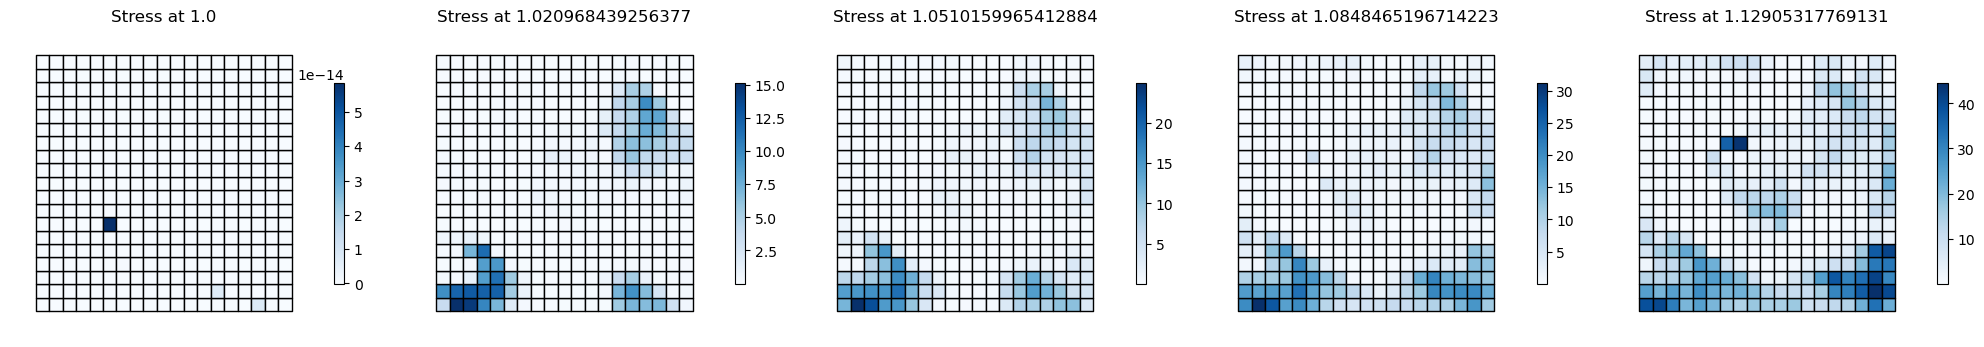

In [19]:
# Stiffness across the domain
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
elem_X = mesh.points[mesh.cells].mean(axis=1)


fig, axes = plt.subplots(1,5,figsize=(25,4))
for lmb, ax in zip(lmbx_hist[::5], axes):
    c_elem = []
    for x, y in elem_X:
        Lambda_inp = jnp.array([x,y]).reshape([-1,2])
        phi = ff_nn(Lambda_inp, Lambda_params).flatten()
        mymodel = NODE_w_unravel(phi)
        c_elem.append(eval_Cauchy_aniso(lmb, lmb, mymodel)[0,0])
    c_elem = np.array(c_elem)
    plotmesh(mesh.cells, mesh.points, c_elem, title='Stress at {}'.format(str(lmb)), ax=ax); 

In [20]:
# Do the FEM with jax-fem instead
def NODE_PK1(u_grad, params, dim):
    theta = 0.0
    #Kinematics
    F_2D = u_grad + jnp.eye(dim)
    C_2D = F_2D.T @ F_2D
    Cinv_2D = jnp.linalg.inv(C_2D)
    detC_2D = jnp.linalg.det(C_2D)
    C33 = 1/detC_2D
    C = jnp.array([  [C_2D[0,0], C_2D[0,1], 0],\
                    [C_2D[1,0], C_2D[1,1], 0],\
                    [0,         0,       C33]])
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
    w0 = jnp.array([-jnp.sin(theta), jnp.cos(theta), 0])
    V0 = jnp.outer(v0, v0)
    W0 = jnp.outer(w0, w0)
    Iv = jnp.einsum('ij,ij',C,V0)
    Iw = jnp.einsum('ij,ij',C,W0)

    # Energy/Stress
    model = NODE_w_unravel(params)
    Psi1 = model.Psi1(I1,I2,Iv,Iw)
    Psi2 = model.Psi2(I1,I2,Iv,Iw)
    Psiv = model.Psiv(I1,I2,Iv,Iw)
    Psiw = model.Psiw(I1,I2,Iv,Iw)
    
    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2] + 2*Psiw*W0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0 + 2*Psiw*W0
    S_2D = S[:2,:2]
    P_2D = F_2D @ S_2D
    return P_2D
NODE_vmap = vmap(NODE_PK1, in_axes=(0,0,None))
def NODE_sigma(u_grad, params, dim):
    F_2D = u_grad + jnp.eye(dim)
    P_2D = NODE_PK1(u_grad, params, dim)
    return P_2D @ F_2D.T
NODE_sigma_vmap = vmap(NODE_sigma, in_axes=(0,0,None))
class NODE_HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: NODE_PK1(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [22]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
elem_X = mesh.points[mesh.cells].mean(axis=1)


params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)




# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.02, 1.05, 1.07, 1.12]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
sigma_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = NODE_HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = NODE_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    sigma_hist.append(sigma)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
sigma_hist = np.array(sigma_hist)

[01-03 20:10:08][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-03 20:10:08][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[01-03 20:10:08][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[01-03 20:10:08][DEBUG] jax_fem: Done pre-computations, took 0.06396603584289551 [s]
[01-03 20:10:08][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[01-03 20:10:08][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-03 20:10:08][DEBUG] jax_fem: Start timing
[01-03 20:10:08][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-03 20:10:10][DEBUG] jax_fem: Function split_and_compute_cell took 2.5254 seconds
[01-03 20:10:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-03 20:10:10][DEBUG] jax_fem: Linear guess solve...
[01-03 20:10:10][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[01-03 20:10:10][DEBUG] jax_fem: PETSc

AssertionError: res_val contains NaN, stop the program!

ValueError: need at least one array to concatenate

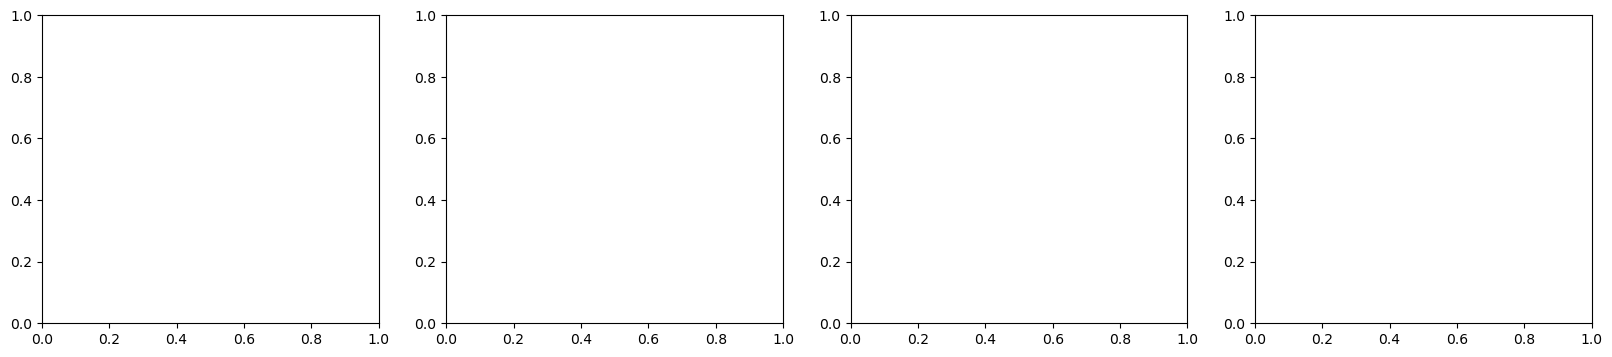

In [23]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist, F_hist, sigma_hist, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))

    plotmesh(mesh.cells, node_x, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)